# Первичный анализ и оценка медицинских организаций Твери и Тверской области


Задачи исследования - создать систему для оценки состояния укомплектованности медицинских организаций (МО) города Твери и Тверской области, спроектировать дашборд в DataLens

[Ссылка на дашборд в DataLens](https://datalens.yandex/a4o5ea4ojpx4w?tab=W0)

Описание данных:

В файле Excel данные представлены на двух листах:

Столбцы со страницы Сотрудники:
- **Unnamed**
- **Дата рождения**
- **Возраст**
- **Пол**  
- **Организация по основной должности**  
- **Основная должность**


Столбцы со страницы Координаты:
- **Организация по основной должности**
- **Сокращенное название организации**
- **Округ/район**
- **Адрес**
- **Координаты**

## Загрузка и оценка данных

In [1]:
# Загружаем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
import gdown
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


скрытый код:

    path ='https://docs.google.com/...'

In [126]:
# Загрузка файла
response = requests.get(path)

# Сохранение файла на диск
with open('data.xlsx', 'wb') as file:
    file.write(response.content)

try:
  data_coord = pd.read_excel('data.xlsx', sheet_name= 'Координаты')
  data_stuff = pd.read_excel('data.xlsx', sheet_name= 'Сотрудники')

except:
  print('Необходимо проверить ссылку на файл')


In [3]:
#Напишем функцию для описания данных в датафреймах
def about_data(insert_df):

  display(insert_df.head(10))
  print()
  print('Информация о датасете:')
  print()
  print(insert_df.info())
  print()
  print(f'В датафрейме {insert_df.shape[0]} строк и {insert_df.shape[1]} столбцов')

In [4]:
about_data(data_stuff)

Unnamed: 0 Дата рождения  Возраст   Пол  \
0           1    1958-01-01       66  Муж.   
1           2    1968-11-13       55  Жен.   
2           3    1950-02-01       74  Муж.   
3           4    1957-02-08       67  Муж.   
4           5    1974-11-14       49  Жен.   
5           6    1957-08-29       66  Муж.   
6           7    1946-03-10       78  Жен.   
7           8    1953-04-17       71  Жен.   
8           9    1966-01-18       58  Жен.   
9          10    1965-06-29       59  Жен.   

                   Организация по основной должности  \
0  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
1  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
2  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
3  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
4  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
5  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
6  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
7  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
8  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
9  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   

                    Основная должность  
0       Врач-анестезиолог-реаниматолог  
1                     Рентгенолаборант  
2  Врач общей практики (семейный врач)  
3       Врач-анестезиолог-реаниматолог  
4  врач общей практики (семейный врач)  
5       Врач-анестезиолог-реаниматолог  
6             Врач-терапевт участковый  
7  врач общей практики (семейный врач)  
8              Врач-педиатр участковый  
9              Врач-педиатр участковый


Информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419 entries, 0 to 1418
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Unnamed: 0                         1419 non-null   int64         
 1   Дата рождения                      1419 non-null   datetime64[ns]
 2   Возраст                            1419 non-null   int64         
 3   Пол                                1419 non-null   object        
 4   Организация по основной должности  1414 non-null   object        
 5   Основная должность                 1414 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 66.6+ KB
None

В датафрейме 1419 строк и 6 столбцов


In [5]:
about_data(data_coord)

Организация по основной должности  \
0  АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ТВЕРСКОЙ...   
1  АКЦИОНЕРНОЕ ОБЩЕСТВО "КОНАКОВСКИЙ ЗАВОД СТАЛЬН...   
2  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ  УЧРЕЖДЕНИЕ ЗДРАВООХ...   
3  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ  УЧРЕЖДЕНИЕ ЗДРАВООХ...   
4  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ  УЧРЕЖДЕНИЕ ЗДРАВООХ...   
5  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ  УЧРЕЖДЕНИЕ ЗДРАВООХ...   
6  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
7  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
8  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
9  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   

  Сокращенное название организации                         Округ/район  \
0                 АНО "БЕЛАЯ РОЗА"         городской округ город Тверь   
1                       АО  "КЗСК"                   Конаковский район   
2              ГБУЗ "КАШИНСКАЯ СП"           Кашинский городской округ   
3             ГБУЗ "КАШИНСКАЯ ЦРБ"           Кашинский городской округ   
4              ГБУЗ "КИМРСКАЯ ЦРБ"         городской округ город Кимры   
5            ГБУЗ "САНДОВСКАЯ ЦРБ"      Сандовский муниципальный округ   
6          ГБУЗ "ОСТАШКОВСКАЯ ЦРБ"        Осташковский городской округ   
7        ГБУЗ "МАКСАТИХИНСКАЯ ЦРБ"                Максатихинский район   
8        ГБУЗ "АНДРЕАПОЛЬСКАЯ ЦРБ"  Андреапольский муниципальный округ   
9              ГБУЗ "БЕЖЕЦКАЯ ЦРБ"                      Бежецкий район   

                                               Адрес  \
0  170100, Тверская область, город Тверь, Тверско...   
1  171252, Тверская область, г. Конаково, ул. Про...   
2  Тверская область, г. Кашин, ул. Карла Маркса, ...   
3  171640, Тверская область, г. Кашин, ул. Вонжин...   
4  171502, Тверская область, г. Кимры, Борковское...   
5  171750, Тверская область, пгт. Сандово, ул. Со...   
6  172730, Тверская область, г. Осташков, пр. Лен...   
7  171900, Тверская область, пгт. Максатиха, ул. ...   
8  172800, Тверская область, г. Андреаполь, ул. Н...   
9  171984, Тверская область, г. Бежецк, Больничны...   

                              Координаты  
0  56.86053266726136, 35.909560612319325  
1   56.72231762064035, 36.78252888653642  
2   57.355114792071056, 37.6091387505305  
3  57.35759162268202, 37.622431951037704  
4   56.83610336308383, 37.36593272292891  
5    58.4682792033075, 36.41935666125257  
6  57.143767576058686, 33.11275175801426  
7   57.78973074023921, 35.87252528460972  
8   56.638628305156246, 32.2802749430645  
9  57.78860348544083, 36.695500123488536


Информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Организация по основной должности  113 non-null    object
 1   Сокращенное название организации   113 non-null    object
 2   Округ/район                        113 non-null    object
 3   Адрес                              113 non-null    object
 4   Координаты                         113 non-null    object
dtypes: object(5)
memory usage: 4.5+ KB
None

В датафрейме 113 строк и 5 столбцов


Вывод:



Датафрейм с информацией о сотрудниках (**data_stuff**) содержит 1419 строк и 6 столбцов. В последних двух столбцах есть пропуски.
Необходимо:
- удалить столбец Unnamed
- переименовать столбцы
- оценить пропуски
- проверить столбец со специальностям, перевести текст в нижний регистр
- проверить на наличие дубликатов


Датафрейм с информацией о сотрудниках (**data_coord**) содержит 113 строк и 5 столбцов. Пропусков нет.
Необходимо:
- переименовать столбцы
- проверить на наличие дубликатов


##Предобработка данных

### Таблица по сотрудникам (data_staff)

Предобработаем первый датафрейм - **data_staff**, где содержится информация о сотрудниках.

In [6]:
# Удалим первый столбец Unnamed: 0
data_stuff.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
data_stuff.columns

Index(['Дата рождения', 'Возраст', 'Пол', 'Организация по основной должности',
       'Основная должность'],
      dtype='object')

Переименуем названия столбцов:
- Дата рождения - **birth_date**
- Возраст - **age**
- Пол - **sex**
- Организация по основной должности - **organization**
- Основная должность - **position**

In [8]:
dict_stuff = {
    'Дата рождения': 'birth_date',
    'Возраст': 'age',
    'Пол': 'sex',
    'Организация по основной должности': 'organization',
    'Основная должность': 'position'
}

In [9]:
data_stuff.rename(columns=dict_stuff, inplace=True)
data_stuff.columns

Index(['birth_date', 'age', 'sex', 'organization', 'position'], dtype='object')

In [10]:
data_stuff.head()

birth_date  age   sex                                       organization  \
0 1958-01-01   66  Муж.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
1 1968-11-13   55  Жен.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
2 1950-02-01   74  Муж.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
3 1957-02-08   67  Муж.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
4 1974-11-14   49  Жен.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   

                              position  
0       Врач-анестезиолог-реаниматолог  
1                     Рентгенолаборант  
2  Врач общей практики (семейный врач)  
3       Врач-анестезиолог-реаниматолог  
4  врач общей практики (семейный врач)

Переименование прошло успешно

In [11]:
# Оценим пропуски
data_stuff.isna().sum().sort_values(ascending=False)

organization    5
position        5
birth_date      0
age             0
sex             0
dtype: int64

In [12]:
data_stuff.query('organization.isna() or position.isna()')

birth_date  age   sex organization position
180  1958-01-26   66  Муж.          NaN      NaN
565  1981-03-28   43  Жен.          NaN      NaN
736  1982-02-06   42  Муж.          NaN      NaN
928  1985-07-28   39  Жен.          NaN      NaN
1405 1996-03-05   28  Жен.          NaN      NaN

In [13]:
print(f'Доля пропусков {(data_stuff.query("organization.isna() or position.isna()")["position"].isna().sum() / data_stuff.shape[0] * 100).round(2)}%')

Доля пропусков 0.35%


Пропуски есть у 5 строк, по обеим колонкам organization и position. Доля этих пропусков менее 0,5%, информацию по ним мы восстановить не сможем, поэтому эти 5 строк удаляем.

In [14]:
# Зафиксируем количество строк до удаления
data_stuff.shape[0]

1419

In [15]:
#Удаляем пропуски
data_stuff.dropna(inplace=True, ignore_index=True)

In [16]:
#Проверим как прошло удаление
display(data_stuff.isna().sum())
print()
print(f'Количество строк после удаления: {data_stuff.shape[0]}')

birth_date      0
age             0
sex             0
organization    0
position        0
dtype: int64


Количество строк после удаления: 1414


Удалено 5 строк, пропусков больше нет.

Теперь проверим столбец со специальностями и приведем значения в этом столбце к нижнему регистру.

In [17]:
display(data_stuff['position'].unique())
print()
print(f'Количество наименований должностей в столбце position {data_stuff["position"].nunique()}')

array(['Врач-анестезиолог-реаниматолог', 'Рентгенолаборант',
       'Врач общей практики (семейный врач)',
       'врач общей практики (семейный врач)', 'Врач-терапевт участковый',
       'Врач-педиатр участковый', 'врач-педиатр участковый',
       'рентгенолаборант', 'врач-анестезиолог-реаниматолог',
       'врач-рентгенолог', 'врач-терапевт участковый', 'врач-хирург',
       'Врач-рентгенолог', 'Врач-хирург'], dtype=object)


Количество наименований должностей в столбце position 14


В столбце position есть повторяющиеся наименования в разном регистре.

In [18]:
#Приводим значения в столбце к нижнему регистру
data_stuff['position'] = data_stuff['position'].str.lower()

In [19]:
display(data_stuff['position'].unique())
print()
print(f'Количество наименований должностей в столбце position {data_stuff["position"].nunique()}')

array(['врач-анестезиолог-реаниматолог', 'рентгенолаборант',
       'врач общей практики (семейный врач)', 'врач-терапевт участковый',
       'врач-педиатр участковый', 'врач-рентгенолог', 'врач-хирург'],
      dtype=object)


Количество наименований должностей в столбце position 7


In [20]:
data_stuff['position'].value_counts()

position
рентгенолаборант                       304
врач-терапевт участковый               218
врач-педиатр участковый                217
врач-анестезиолог-реаниматолог         208
врач общей практики (семейный врач)    179
врач-хирург                            147
врач-рентгенолог                       141
Name: count, dtype: int64

Количество наименований сократилось в два раза.

Посмотрим уникальные наименования мед органицаций.

In [21]:
data_stuff['organization'].nunique()

113

In [22]:
#Сравним каждое последующее название мед.организации, чтобы выявить дубликаты, вычислим расстояния Левнштейна между уникальными названиями мед организаций

for med_ind, med_inst_1 in enumerate(data_stuff['organization'].unique()):
    if (data_stuff['organization'].nunique()-1) != med_ind:
      for med_inst_2 in data_stuff['organization'].unique()[(med_ind+1):]:
        if fuzz.ratio(med_inst_1, med_inst_2) >= 99:

          print(med_inst_1)
          print(med_inst_2)
          print(50*'-')

ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА №1"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА №2"
--------------------------------------------------
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА №1"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА № 3"
--------------------------------------------------
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ГОРОДСКАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА №7"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ГОРОДСКАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА № 6"
--------------------------------------------------
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ТВЕРСКОЙ ОБЛАСТНОЙ КЛИНИЧЕСКИЙ НАРКОЛОГИЧЕСКИЙ ДИСПАНСЕР"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ТВЕРСКОЙ ОБЛА

Дубликатов в названиях с разным регистром нет.

Теперь проверим датафрейм на наличие явных дубликатов:

In [23]:
data_stuff.duplicated().sum()

1

In [24]:
old_colwidth = pd.options.display.max_colwidth

data_stuff[data_stuff.duplicated(keep=False)]

birth_date  age   sex                                       organization  \
957  1990-11-07   33  Муж.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
1225 1990-11-07   33  Муж.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   

                            position  
957   врач-анестезиолог-реаниматолог  
1225  врач-анестезиолог-реаниматолог

In [25]:
data_stuff.loc[(data_stuff['organization'] == 'ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ОБЛАСТНАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА"') & (data_stuff['position'] == 'врач-анестезиолог-реаниматолог')].value_counts('sex')

sex
Муж.    22
Жен.    16
Name: count, dtype: int64

Да есть одно полное совпадение, маловероятно, что это два разных человека, с одной и той же датой рождения, должностью, работающие в одном и том же учреждении. Поэтому этот дубликат удаляем.

In [26]:
data_stuff.shape[0]

1414

In [27]:
data_stuff.drop_duplicates(inplace=True, ignore_index=True)

In [28]:
data_stuff.shape[0]

1413

Оценим неявные дубликаты

In [29]:
# Количество неявных дубликатов по столбцам 'birth_date', 'sex', 'position'
data_stuff.duplicated(subset=['birth_date', 'sex', 'position']).sum()

5

In [30]:
data_stuff[data_stuff.duplicated(subset=['birth_date', 'sex','position'], keep=False)]

birth_date  age   sex                                       organization  \
1    1968-11-13   55  Жен.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
92   1968-11-13   55  Жен.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
182  1967-06-01   57  Жен.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ  УЧРЕЖДЕНИЕ ЗДРАВООХ...   
243  1967-06-01   57  Жен.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
388  1976-11-15   47  Жен.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
562  1976-11-15   47  Жен.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
840  1987-08-14   36  Муж.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
1140 1987-08-14   36  Муж.  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ХИРУ...   
1143 1997-04-03   27  Жен.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
1164 1997-04-03   27  Жен.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   

                      position  
1             рентгенолаборант  
92            рентгенолаборант  
182           рентгенолаборант  
243           рентгенолаборант  
388           рентгенолаборант  
562           рентгенолаборант  
840                врач-хирург  
1140               врач-хирург  
1143  врач-терапевт участковый  
1164  врач-терапевт участковый

Да, неявные дубликаты есть, скорей всего это мед рабоники, работающие в нескольких организациях, их мы удалять не будем.

Посмотрим по связке дата рождения - организация.

In [31]:
data_stuff[data_stuff.duplicated(subset=['birth_date', 'organization'], keep=False)]

birth_date  age   sex                                       organization  \
941  1994-12-31   29  Муж.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   
1094 1994-12-31   29  Жен.  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...   

                     position  
941   врач-педиатр участковый  
1094  врач-педиатр участковый

Тоже есть дубликат, но различие по столбцу пол. Здесь мы также не будем удалять дубликат, так как не можем на 100% утверждать, что это один и тот же человек без номера ID, например.

Теперь оценим вторую таблицу с данными о мед организациях.

### Таблица по мед.организациям (data_coord)

Перейдем ко второму датафрейму **data_coord**.

Заменим названия столбцов:
 - Организация по основной должности - **organization**
 - Сокращенное название организации - **short_name**
 - Округ/район - **region**
 - Адрес - **adds**
 - Координаты - **coordinates**



In [32]:
data_coord.columns

Index(['Организация по основной должности', 'Сокращенное название организации',
       'Округ/район', 'Адрес', 'Координаты'],
      dtype='object')

In [33]:
dict_coord = {
    'Организация по основной должности': 'organization',
    'Сокращенное название организации': 'short_name',
    'Округ/район': 'region',
    'Адрес': 'adds',
    'Координаты': 'coordinates'
}

In [34]:
#Переименуем столбцы
data_coord.rename(columns=dict_coord, inplace=True)

In [35]:
data_coord.columns

Index(['organization', 'short_name', 'region', 'adds', 'coordinates'], dtype='object')

In [36]:
data_coord.head()

organization            short_name  \
0  АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ТВЕРСКОЙ...      АНО "БЕЛАЯ РОЗА"   
1  АКЦИОНЕРНОЕ ОБЩЕСТВО "КОНАКОВСКИЙ ЗАВОД СТАЛЬН...            АО  "КЗСК"   
2  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ  УЧРЕЖДЕНИЕ ЗДРАВООХ...   ГБУЗ "КАШИНСКАЯ СП"   
3  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ  УЧРЕЖДЕНИЕ ЗДРАВООХ...  ГБУЗ "КАШИНСКАЯ ЦРБ"   
4  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ  УЧРЕЖДЕНИЕ ЗДРАВООХ...   ГБУЗ "КИМРСКАЯ ЦРБ"   

                        region  \
0  городской округ город Тверь   
1            Конаковский район   
2    Кашинский городской округ   
3    Кашинский городской округ   
4  городской округ город Кимры   

                                                adds  \
0  170100, Тверская область, город Тверь, Тверско...   
1  171252, Тверская область, г. Конаково, ул. Про...   
2  Тверская область, г. Кашин, ул. Карла Маркса, ...   
3  171640, Тверская область, г. Кашин, ул. Вонжин...   
4  171502, Тверская область, г. Кимры, Борковское...   

                             coordinates  
0  56.86053266726136, 35.909560612319325  
1   56.72231762064035, 36.78252888653642  
2   57.355114792071056, 37.6091387505305  
3  57.35759162268202, 37.622431951037704  
4   56.83610336308383, 37.36593272292891

Переименование прошло успешно.

Проверим на наличие явных и неявных дубликатов.

In [37]:
data_coord.duplicated().sum()

0

Явных дубликатов нет. Проверим на неявные дубликаты.

In [38]:
data_coord[data_coord.duplicated(subset=['adds', 'coordinates'], keep=False)]

Empty DataFrame
Columns: [organization, short_name, region, adds, coordinates]
Index: []

In [39]:
data_coord[data_coord.duplicated(subset=['organization', 'coordinates'], keep=False)]

Empty DataFrame
Columns: [organization, short_name, region, adds, coordinates]
Index: []

In [40]:
data_coord[data_coord.duplicated(subset=['short_name', 'coordinates'], keep=False)]

Empty DataFrame
Columns: [organization, short_name, region, adds, coordinates]
Index: []

In [41]:
data_coord[data_coord.duplicated(subset=['coordinates'], keep=False)]

organization        short_name  \
95   ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "СОФИ...  ООО "СОФИТЕЛЬ Р"   
102  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ХИРУ...    ООО "ХИРУРГИЯ"   

                          region  \
95   городской округ город Тверь   
102  городской округ город Тверь   

                                                  adds  \
95   170001, Тверская область, г Тверь, ул Спартака...   
102  170001, Тверская область, город Тверь, ул Спар...   

                             coordinates  
95   56.85261396057918, 35.8811559111127  
102  56.85261396057918, 35.8811559111127

У нас есть один неявный дубликат по координатам, но названия мед организаций у этих дубликатов разные, делаем вывод, что это разные компании, находящиеся в одном здании, оставляем.

Проверим на дубликаты по адресу.

In [42]:
old_colwidth = pd.options.display.max_colwidth
pd.options.display.max_colwidth = None

data_coord[data_coord.duplicated(subset=['adds'], keep=False)]

organization  \
84                                                                               ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "КЛИНИКА "ЦЕНТРОМЕД""   
103                                                                                        ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"   
109                      ФЕДЕРАЛЬНОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ "МЕДИКО-САНИТАРНАЯ ЧАСТЬ № 69 ФЕДЕРАЛЬНОЙ СЛУЖБЫ ИСПОЛНЕНИЯ НАКАЗАНИЙ"   
110  филиал «Больница» Федерального казенного учреждения здравоохранения «Медико-санитарная часть № 69 Федеральной службы исполнения наказаний»   

                                     short_name                       region  \
84                    ООО "КЛИНИКА "ЦЕНТРОМЕД""  городской округ город Тверь   
103                             ООО "ЦЕНТРОМЕД"  городской округ город Тверь   
109                     ФКУЗ МСЧ-69 ФСИН РОССИИ  городской округ город Тверь   
110  филиал "Больница"  ФКУЗ МСЧ-69 ФСИН России  городской округ город Тверь   

                                                                      adds  \
84   170026, Тверская область, город Тверь, Комсомольский пр-кт, д.11 к.2    
103  170026, Тверская область, город Тверь, Комсомольский пр-кт, д.11 к.2    
109            170100, Тверская область, город Тверь, ул. Вагжанова, д.19    
110            170100, Тверская область, город Тверь, ул. Вагжанова, д.19    

                               coordinates  
84   56.870527676115174, 35.91276790347038  
103   56.87054480638941, 35.91280403109543  
109  56.851232009467076, 35.93780137517276  
110   56.85137868021394, 35.93789763522566

Действительно, на сайте клиники ЦЕНТРОМЕД указана только одна клиника по этому адресу. Данный дубликат мы удаляем, но перед этим проверяем первый датафрайм, и заменяем название организации там.

В случае с ФКУЗ мы не можем исключить того, что это две разные организации, поэтому здесь ничего менять не будем.

In [43]:
#Проверим датафрейм с персоналом на наличие организации ЦЕНТРОМЕД
data_stuff.query('organization.str.contains("ЦЕНТРОМЕД", case=False, na=False)')

birth_date  age   sex  \
451 1965-03-11   59  Муж.   
558 1975-06-28   49  Жен.   
585 1976-01-30   48  Жен.   
646 1956-04-27   68  Жен.   

                                                       organization  \
451            ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"   
558            ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"   
585  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "КЛИНИКА "ЦЕНТРОМЕД""   
646            ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"   

                                position  
451                          врач-хирург  
558                          врач-хирург  
585                     врач-рентгенолог  
646  врач общей практики (семейный врач)

In [44]:
#Переназовем поле
data_stuff.iloc[585,3] = 'ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"'

In [45]:
#Проверим замену названия
data_stuff.query('organization.str.contains("ЦЕНТРОМЕД", case=False, na=False)')

birth_date  age   sex  \
451 1965-03-11   59  Муж.   
558 1975-06-28   49  Жен.   
585 1976-01-30   48  Жен.   
646 1956-04-27   68  Жен.   

                                             organization  \
451  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"   
558  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"   
585  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"   
646  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"   

                                position  
451                          врач-хирург  
558                          врач-хирург  
585                     врач-рентгенолог  
646  врач общей практики (семейный врач)

Теперь можно мерейти к таблице с организациями и удалить дубликат.

In [46]:
#Фиксируем количество организаций до удаления
data_coord.shape[0]

113

In [47]:
data_coord = data_coord[data_coord['short_name'] != 'ООО "КЛИНИКА "ЦЕНТРОМЕД""']

In [48]:
data_coord.reset_index(inplace=True, drop=True)

In [49]:
#Проверяем результат удаления
data_coord.shape[0]

112

In [50]:
data_coord.query('organization.str.contains("ЦЕНТРОМЕД", case=False, na=False)')

organization       short_name  \
102  ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"  ООО "ЦЕНТРОМЕД"   

                          region  \
102  городской округ город Тверь   

                                                                      adds  \
102  170026, Тверская область, город Тверь, Комсомольский пр-кт, д.11 к.2    

                              coordinates  
102  56.87054480638941, 35.91280403109543

Удаление дубликата в data_coord и замена названия организации ЦЕНТРОМЕД прошло успешно.



Оценим количество уникальных названий (полных и сокращенных) и на предмет дублирования.

In [51]:
data_coord['short_name'].nunique()

112

In [52]:
data_coord['organization'].nunique()

112

Количество названий (полных и сокращенных) совпадает и равняется количеству строк в таблице, и также совпадает с количеством уникальных названий мед организаций с первой таблицей.

Проверим названия организаций на совпадение, опятьже с помощью вычисления расстояния Левенштейна

In [53]:
def fuzz_mo(data, col):
    """
    Функция выичисляет расстояния Левенштейна и выводит
    совпадения на 99% и более
    """
    # Получаем значение и индекс
    for med_ind, med_inst_1 in enumerate(data[col].unique()):
        # Проверяем, чтобы индекс не был последним
        if (data[col].nunique()-1) != med_ind:
            # Запускаем цикл по проверке расстояния Левенштейна
            for med_inst_2 in data[col].unique()[(med_ind+1):]:
                if fuzz.ratio(med_inst_1, med_inst_2) >= 99:
                    # Вывод данных при совпадении условий
                    print(med_inst_1)
                    print(med_inst_2)
                    print(50*'*')
    # return закрывает тело функции и возвращает пустое значение
    return

In [54]:
# Проверяем функцию, на прошлом датасете

fuzz_mo(data_stuff, 'organization')

ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА №1"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА №2"
**************************************************
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА №1"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА № 3"
**************************************************
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ГОРОДСКАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА №7"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ГОРОДСКАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА № 6"
**************************************************
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ТВЕРСКОЙ ОБЛАСТНОЙ КЛИНИЧЕСКИЙ НАРКОЛОГИЧЕСКИЙ ДИСПАНСЕР"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ТВЕРСКОЙ ОБЛА

Работает корректно, проверяем на втором датасете.

In [55]:
# Второй датасет

fuzz_mo(data_coord, 'organization')

ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ГОРОДСКАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА № 6"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ГОРОДСКАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА №7"
**************************************************
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КОНАКОВСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СОНКОВСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА"
**************************************************
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СПИРОВСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ФИРОВСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА"
**************************************************
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА № 3"
ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМА

In [56]:
# Второй датасет

fuzz_mo(data_coord, 'short_name')

Все в порядке, можем переходить к следующему этапу.

### Добавление новых столбцов

Проведем категоризацию по типам организации.

In [57]:
#Создаем список с сокращенными названиями

def extract_type(org_name):
  match = re.findall(r'^[А-Яа-я]{2,}', org_name)
  return match[0] if match else ''

data_coord['abbr'] = data_coord['short_name'].apply(extract_type)

In [58]:
print(f'Количество типов организаций: {data_coord["abbr"].nunique()}')
print()
data_coord['abbr'].unique()

Количество типов организаций: 12



array(['АНО', 'АО', 'ГБУЗ', 'ГКУЗ', 'ООО', 'ФБУЗ', 'ФГБОУ', 'ФГБУЗ',
       'ФКУЗ', 'филиал', 'ФИЛИАЛ', 'ЧУЗ'], dtype=object)

Посмотрим, можем ли мы отнести филиалы к организациаям.

In [59]:
data_coord.query('abbr.str.lower() == "филиал"')

organization  \
109  филиал «Больница» Федерального казенного учреждения здравоохранения «Медико-санитарная часть № 69 Федеральной службы исполнения наказаний»   
110                                                      ФИЛИАЛ №1 ОБЩЕСТВА С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "МЕДИЦИНСКИЙ ЦЕНТР-ТОМОГРАФИЯ ПЛЮС"   

                                     short_name                       region  \
109  филиал "Больница"  ФКУЗ МСЧ-69 ФСИН России  городской округ город Тверь   
110         ФИЛИАЛ №1 ООО  "МЦ-ТОМОГРАФИЯ ПЛЮС"  городской округ город Тверь   

                                                            adds  \
109  170100, Тверская область, город Тверь, ул. Вагжанова, д.19    
110                             г. Тверь, Беляковский переулок 9   

                              coordinates    abbr  
109  56.85137868021394, 35.93789763522566  филиал  
110  56.85441516256905, 35.88541471297727  ФИЛИАЛ

Первый филиал относится к ФКУЗ, второй к ООО.

In [60]:
data_coord.iloc[109,5] = 'ФКУЗ'
data_coord.iloc[110,5] = 'ООО'

In [61]:
data_coord.iloc[109:111]

organization  \
109  филиал «Больница» Федерального казенного учреждения здравоохранения «Медико-санитарная часть № 69 Федеральной службы исполнения наказаний»   
110                                                      ФИЛИАЛ №1 ОБЩЕСТВА С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "МЕДИЦИНСКИЙ ЦЕНТР-ТОМОГРАФИЯ ПЛЮС"   

                                     short_name                       region  \
109  филиал "Больница"  ФКУЗ МСЧ-69 ФСИН России  городской округ город Тверь   
110         ФИЛИАЛ №1 ООО  "МЦ-ТОМОГРАФИЯ ПЛЮС"  городской округ город Тверь   

                                                            adds  \
109  170100, Тверская область, город Тверь, ул. Вагжанова, д.19    
110                             г. Тверь, Беляковский переулок 9   

                              coordinates  abbr  
109  56.85137868021394, 35.93789763522566  ФКУЗ  
110  56.85441516256905, 35.88541471297727   ООО

Замена прошла успешно.

In [62]:
print(f'Количество типов организаций: {data_coord["abbr"].nunique()}')
print()
data_coord['abbr'].unique()

Количество типов организаций: 10



array(['АНО', 'АО', 'ГБУЗ', 'ГКУЗ', 'ООО', 'ФБУЗ', 'ФГБОУ', 'ФГБУЗ',
       'ФКУЗ', 'ЧУЗ'], dtype=object)

Теперь можем произвести категоризацию по типам организаций:

**Категории:**

**1. Государственные учреждения:**
* ГБУЗ (Государственное бюджетное учреждение здравоохранения)

**2. Казенные учреждения:**
* ГКУЗ (Государственное казенное учреждение здравоохранения)
* ФКУЗ (Федеральное казенное учреждение здравоохранения)

**3. Относящие к федеральному медико-биологическому агентству (ФМБА)**:
* ФГБУЗ (Федеральное государственное бюджетное учреждение здравоохранения)
* ФБУЗ (Федеральное бюджетное учреждение здравоохранения)

**4. Частные компании:**
* ООО (Общество с ограниченной ответственностью)
* АО (Акционерное общество)

**5. Некоммерческие организации:**
* АНО (Автономная некоммерческая организация)
* ЧУЗ (Частное учреждение здравоохранения)

**6. Образовательные учреждения:**
* ФГБОУ (Федеральное государственное бюджетное образовательное учреждение)

In [63]:
def categorize_org(org):
  if org in ['ГБУЗ']:
    return 'государственное'

  elif org in ['ГКУЗ', 'ФКУЗ']:
    return 'казенное'

  elif org in ['ФГБУЗ', 'ФБУЗ']:
    return 'ФМБА'
  elif org in ['ООО', 'АО']:
    return 'частное'
  elif org in ['АНО', 'ЧУЗ']:
    return 'некоммерческое'

  elif org in ['ФГБОУ']:
    return 'образовательное'
  else:
    return 'прочее'

In [64]:
#Применяем функцию и проверяем
data_coord['org_cat'] = data_coord['abbr'].apply(categorize_org)
data_coord['org_cat'].value_counts()

org_cat
государственное    68
частное            34
казенное            4
ФМБА                3
некоммерческое      2
образовательное     1
Name: count, dtype: int64

Основное количество организаций у нас государственные и частные.

### Вывод

Мы предобработали таблицы **data_stuff**(информация о сотрудниках) и **data_coord** (информация о мед.организациях). Для таблицы **data_stuff** мы выполнили следующее:
1. Удалили столбец Unnamed и переименовали остальные столбцы
2. Удалили 5 пропусков
3. Удалили 1 полный дубликат
4. Привели названия специальностей к нижнему регистру, что позволило убрать дублирование в специальностях.
6. Проверили названия мед организаций на наличие дубликатов. Дубликатов там не выявили.

Для таблицы **data_coord**:
1. Также переименовали столбцы
2. Проверили таблицу на наличие явных и неявных дубликатов, их не обнаружили.
3. добавили два столбца, перый с юридической формой организации, второй с категорией организации.

**Итого:** У нас 1413 специалистов и 112 организаций.

##Исследовательский анализ данных

### Распределение по специальностям

Посмотрим на распределение сотрудников по должностям.

In [65]:
print(f'Всего специалистов {data_stuff["age"].count()}')

Всего специалистов 1413


In [66]:
data_stuff.groupby('position', as_index=False).agg({'organization':'count','age':'median'}).sort_values(by='organization', ascending=False)

position  organization   age
6                     рентгенолаборант           304  48.0
4             врач-терапевт участковый           218  34.0
2              врач-педиатр участковый           217  35.0
1       врач-анестезиолог-реаниматолог           207  41.0
0  врач общей практики (семейный врач)           179  53.0
5                          врач-хирург           147  47.0
3                     врач-рентгенолог           141  43.0

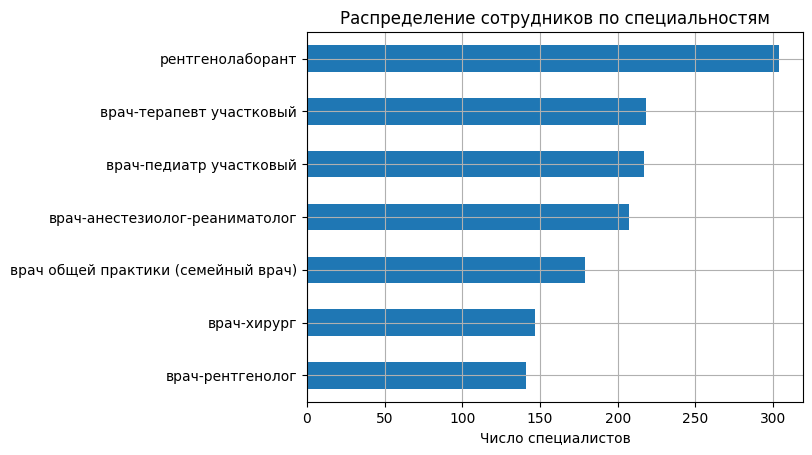

In [67]:
#Построим график по распределению врачей по должностям
data_stuff.groupby('position')['organization'].count().sort_values().plot(kind='barh', grid=True)

plt.title('Распределение сотрудников по специальностям')
plt.ylabel(None)
plt.xlabel('Число специалистов')
plt.show()

Наибольшее количество сотрудников работает по специальности - **рентгенолаборант**, наименьшее - **врач рентгенолог и хирург** . Врачей по специальности участковый терапевт и педиатр одинаковое количество.

### Распределение по возрасту

Посмотрим на возраст сотрудников

count    1413.000000
mean       45.782732
std        15.185312
min        21.000000
25%        31.000000
50%        44.000000
75%        59.000000
max        86.000000
Name: age, dtype: float64

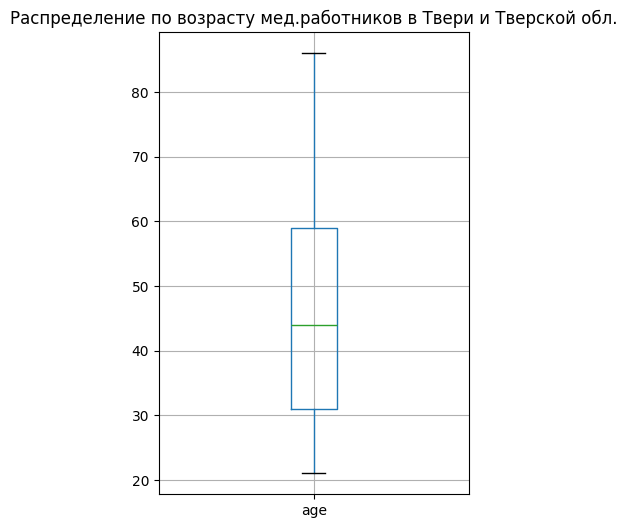

In [68]:
display(data_stuff['age'].describe())
data_stuff[['birth_date','age']].boxplot(figsize=(4,6))

plt.title('Распределение по возрасту мед.работников в Твери и Тверской обл.')
plt.show()

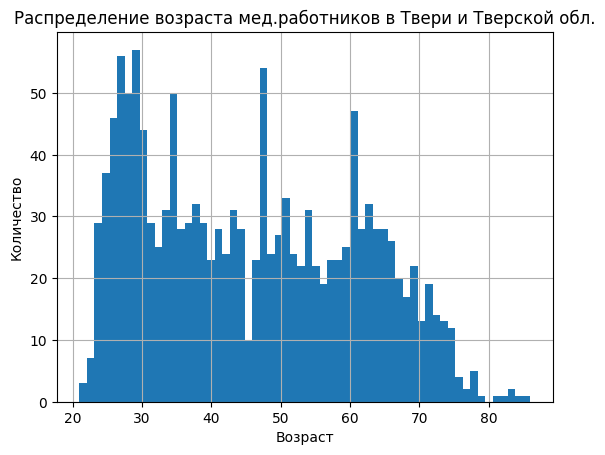

In [69]:
data_stuff['age'].hist(bins=60)

plt.title('Распределение возраста мед.работников в Твери и Тверской обл.')
plt.ylabel('Количество')
plt.xlabel('Возраст')
plt.show()

Медианный возраст сотрудников - 44 года, при этом у нас есть большое количество стотрудников в возрасте от 22-24 до 30. Также у распределения большой 'хвост' справа, это говорит о большой вариации возраста сотрудников выше 44 года.

Разделим сотрудников по группам возрастов:
- до 24 лет
- 24 - 27 лет
- 28 - 35 лет
- 36 - 59 лет
- 60 - 69 лет
- 70+


In [70]:
#Напишем функцию, которая категоризирует возраст по группам
def categorize_age(age):

  if age <24:
    return 'до 24'
  elif 24 <= age <=27:
    return 'с 24 до 27'
  elif 27 < age <=35:
    return 'с 28 до 35'
  elif 35 < age < 60:
    return 'с 36 до 59'
  elif 60 <= age <=69:
    return 'с 60 до 69'
  else:
    return '70+'

In [71]:
#Применяем функцию для категоризации
data_stuff['age_category'] = data_stuff['age'].apply(categorize_age)

In [72]:
#Сгруппируем по созданным категориям и рассчитаем количество
data_stuff.groupby(['age_category'], as_index=False)['birth_date'].count().sort_values(by='birth_date', ascending=False)

age_category  birth_date
4   с 36 до 59         612
3   с 28 до 35         286
5   с 60 до 69         248
2   с 24 до 27         168
0          70+          89
1        до 24          10

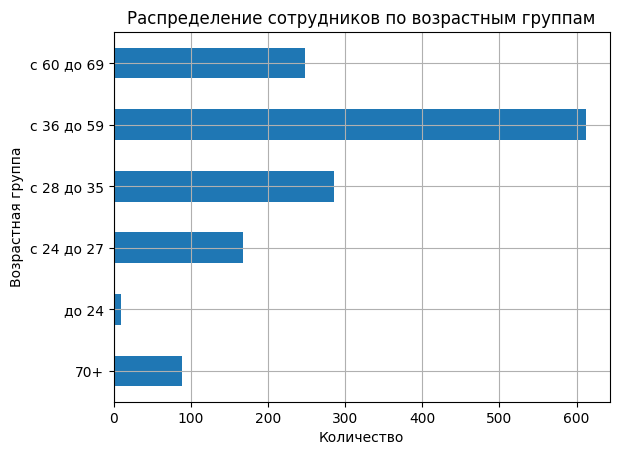

In [124]:
data_stuff.groupby(['age_category'])['birth_date'].count().plot(kind='barh', grid=True)

plt.title('Распределение сотрудников по возрастным группам')
plt.ylabel('Возрастная группа')
plt.xlabel('Количество')
plt.show()

Основное количество сотрудников (чуть более 600 человек) в возрасте с 36 по 59 лет.
Также в группе 70+ у нас почти 100 человек. Важно понимать, сотрудники из этой категории уходят на пенсию, и необходимо готовить специалистов для их замены.


Посмотрим на распределение возрастов по разным специальностям.

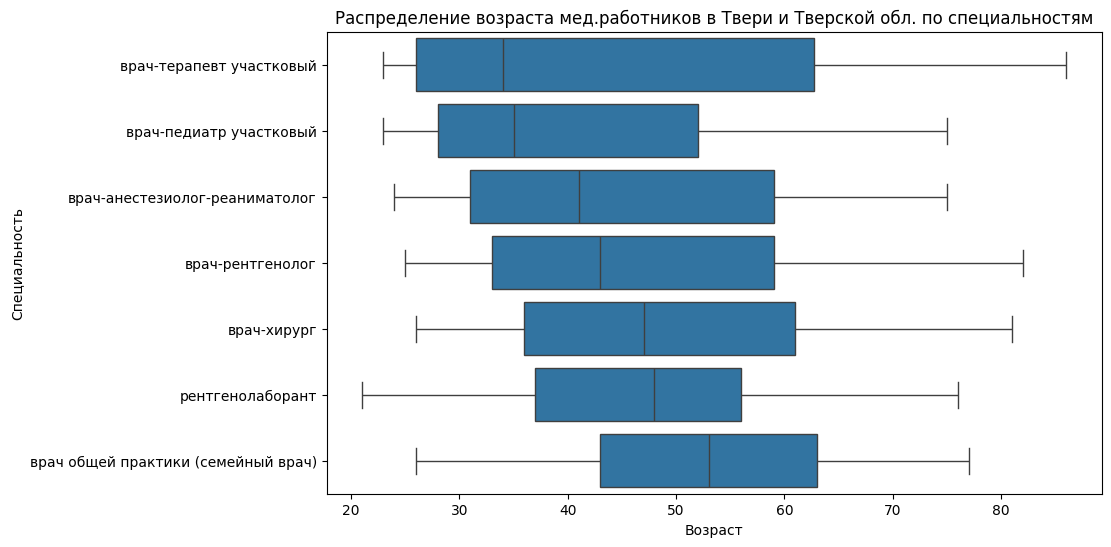

In [74]:
plt.figure(figsize=(10,6))

sns.boxplot(data=data_stuff, x='age', y='position', order=data_stuff.groupby('position')['age'].median().sort_values().index)

plt.title('Распределение возраста мед.работников в Твери и Тверской обл. по специальностям')
plt.xlabel('Возраст')
plt.ylabel('Специальность')

plt.show()

Самая большая вариация по возрасту в специальности **участковый терапевт**, при наименьшем медианном возрасте 36-38 лет в сравнении с остальными специальностями, очень большая вариативность данных справа, значит много высоковозрастных сотрудников по этой специальности.

Самый высокий медианный возраст у врачей общей практики, 53-54 года.

Самые молодые сотрудники у нас работают на позиции **рентгенолаборант**, 21-22 года, при медианном возрасте на этой позиции около 48 лет.

### Распределение по полу

Оценим распределение сотрудников по полу.

In [75]:
data_stuff['sex'].value_counts()

sex
Жен.    981
Муж.    432
Name: count, dtype: int64

Женщин в мед организациях работает в два раза больше, чем мужчин.

Теперь посмотрим по отдельным специальностям распределение по возрастным группам и полу.

In [76]:
stuff = data_stuff['position'].unique()
stuff

array(['врач-анестезиолог-реаниматолог', 'рентгенолаборант',
       'врач общей практики (семейный врач)', 'врач-терапевт участковый',
       'врач-педиатр участковый', 'врач-рентгенолог', 'врач-хирург'],
      dtype=object)

In [77]:
""" Эта функция отображает два графика, гистограмма распределения по возрастам
    и распределение по полу с учетом выбранной специальности
"""
def doctors(name):
  plt.figure(figsize=(10,4))

  #Строим столбчатую диаграмму по возрастным группам
  plt.suptitle(f'Распределение по возрастным группам и полу в специальности {name}')

  plt.subplot(1,2,1)
  viz1 = data_stuff.query('position == @name').groupby('age_category')['age'].count().sort_values().plot(kind='barh',
                                                                                      grid=True,
                                                                                      color='lightseagreen')
  plt.ylabel('Возрастная категория')
  plt.xlabel('количество')

  #Строим круговую диаграмму диаграмму распределения по полу
  plt.subplot(1,2,2)
  viz2 = data_stuff.query('position == @name').groupby('sex')['birth_date'].count().plot(kind='pie',
                                                                                         startangle = 90,
                                                                                         colors=['salmon', 'lightseagreen'],
                                                                                         autopct='%1.1f%%')
  plt.ylabel(None)
  plt.show()
  return viz1, viz2

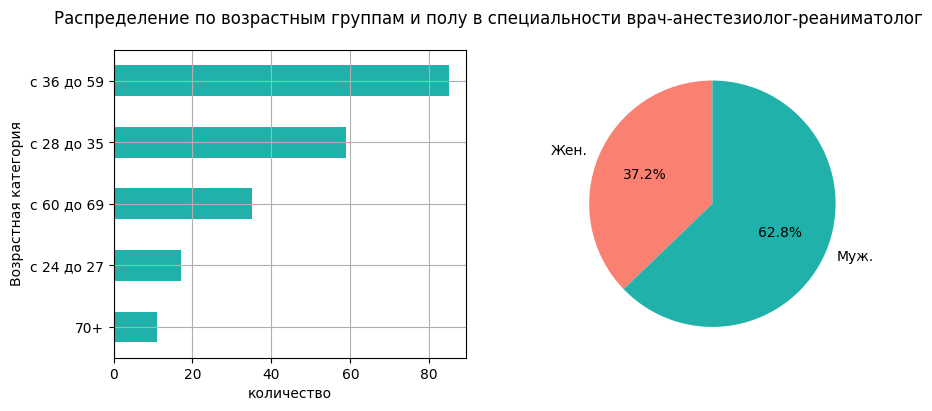

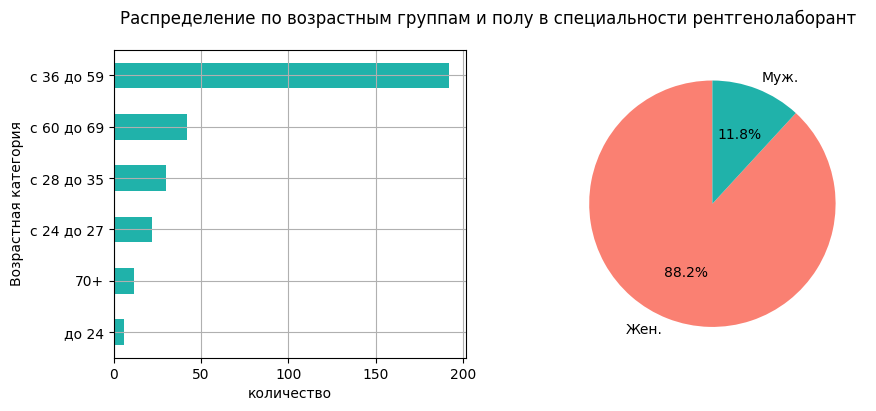

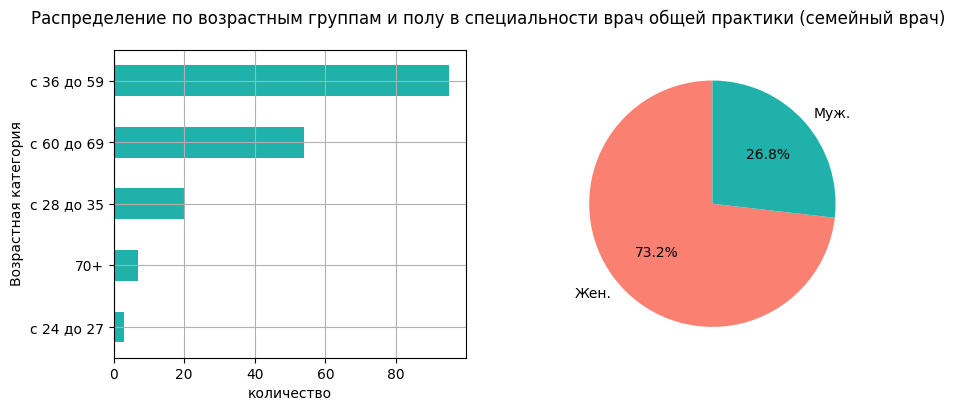

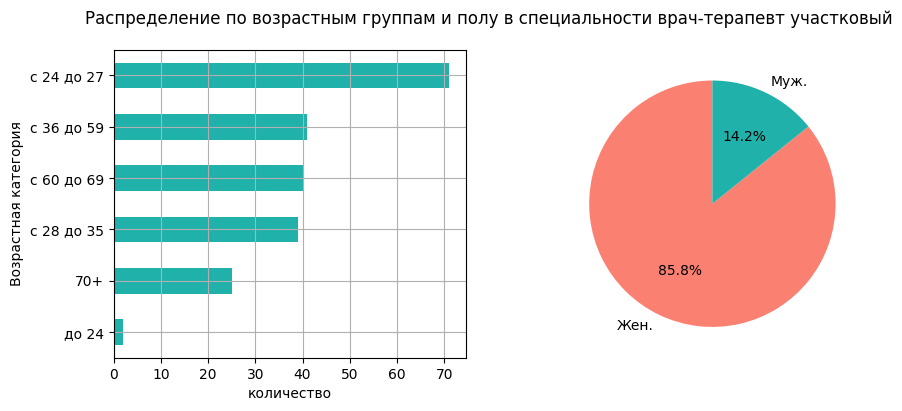

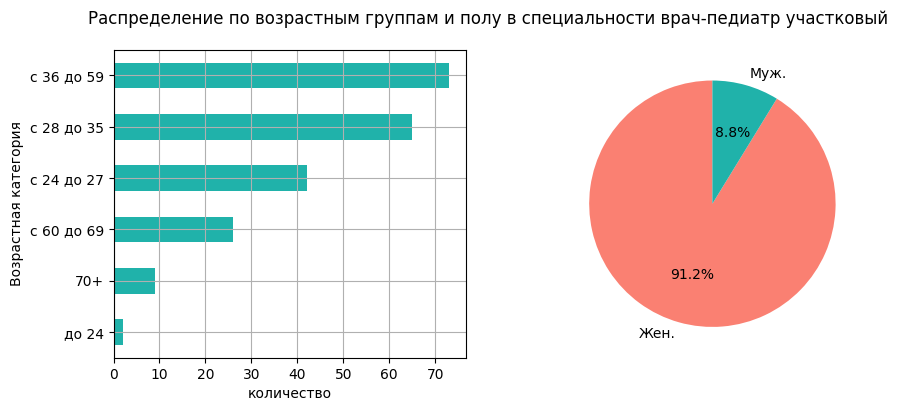

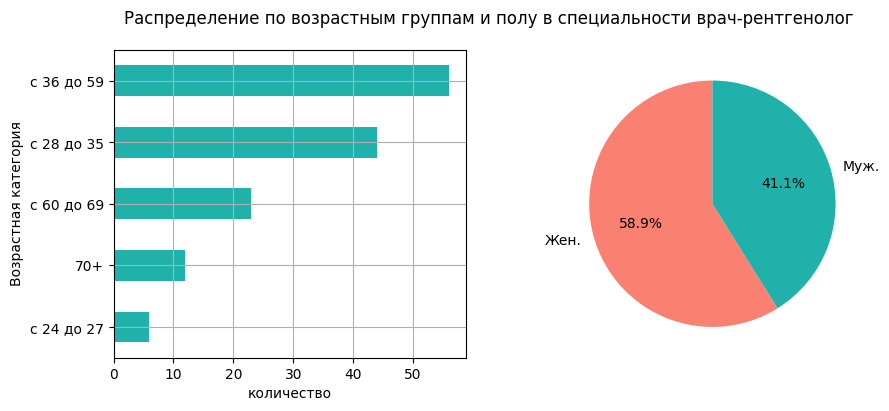

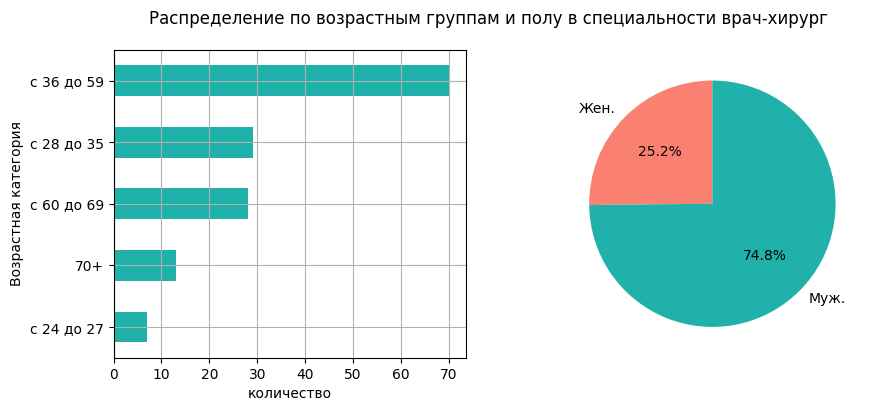

In [78]:
#Выводим поочередно гравики для каждой должности
for st in stuff:
  doctors(st)

In [79]:
pd.pivot_table(data_stuff, values='age', index='position', columns='sex', aggfunc='mean')

sex                                       Жен.       Муж.
position                                                 
врач общей практики (семейный врач)  50.335878  55.791667
врач-анестезиолог-реаниматолог       38.948052  47.876923
врач-педиатр участковый              41.383838  36.684211
врач-рентгенолог                     45.024096  47.982759
врач-терапевт участковый             42.935829  45.419355
врач-хирург                          48.189189  48.272727
рентгенолаборант                     48.227612  36.944444

Мужчины работают в основном по специальностям **врач-хирург** (почти 75% мужчин в этой специальности) и **анестезиолог-реаниматолог** (почти 63%). При этом медианный возраст мужчин хирургов и женщин хирургов одинаковый 48 лет, а анестезиологов-реаниматологов нет, у мужчин медианный возраст почти 48 лет, у женщин 39.

Больше всего женщин работает по специальности **врач-педиатр** - 91% (медианный возраст 41 год), **рентгенолаборант** - 88%, **врач-терапевт** почти 86%, **врач общей практики** - 73% женщин (медианный возраст женщин 50 лет). Большая разница в медианном возрасте рентгенолаборантов, где у женщин медианный возраст 48, у мужчин 37 лет.

Можно сказать, что наиболее равномерное распределение по полу в специальности **врач-рентгенолог**, где работает 59% женщин и 41% мужчин. С медианным возрастом у женщин 45 лет, у мужчин 48 лет.


### Распределение по организациям

Теперь посмотрим распределение в связке специальность - тип организации

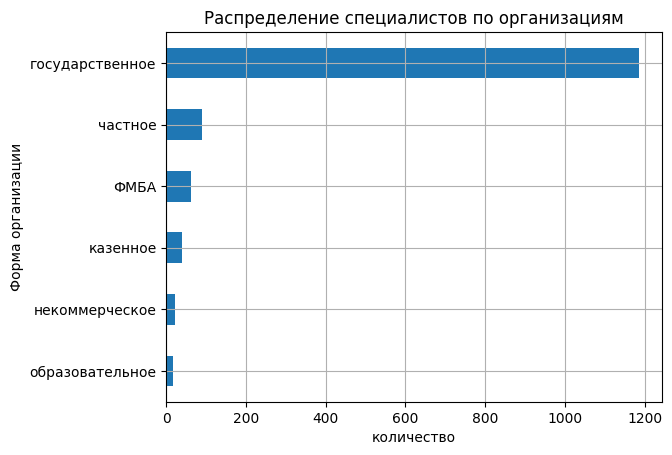

In [80]:
data_stuff.merge(data_coord, how='left', on='organization')['org_cat'].value_counts(ascending=True).plot(kind='barh', grid=True)
plt.title('Распределение специалистов по организациям')
plt.xlabel('количество')
plt.ylabel('Форма организации')
plt.show()

Подавляющее большинство сотрудников из нашей выборки работает в государственных медицинских учреждениях, почти 1200 человек.

### **Вывод:**
В нашей выборке 1413 специалистов.
Наибольшее количество сотрудников работает по специальности - **рентгенолаборант** 300 сотрудников, наименьшее - **врач рентгенолог** и **хирург**, 141 и 147 сотрудников соответственно.
Врачей по специальности участковый терапевт и педиатр почти одинаковое количество, по 218 и 217 сотрудников. У этих специальностей и самый низкий медианный возраст 34-35 лет.

Самый большой медианный возраст у семейных врачей 53 года.

Основное количество сотрудников (чуть более 600 человек) в возрасте с 36 по 59 лет. **Также в группе 70+ у нас почти 100 человек**. Важно понимать, сотрудники из этой категории уходят на пенсию, и необходимо готовить специалистов для их замены.

Самая большая вариация по возрасту в специальности участковый терапевт, при наименьшем медианном возрасте 36-38 лет в сравнении с остальными специальностями, очень большая вариативность данных справа, значит много высоковозрастных сотрудников по этой специальности.

Самые молодые сотрудники у нас работают на позиции рентгенолаборант, 21-22 года, при медианном возрасте на этой позиции около 48 лет.

В нашей выборке 981 женщина и 432 мужчины.

Мужчины работают в основном по специальностям **врач-хирург** (почти 75% мужчин в этой специальности) и **анестезиолог-реаниматолог** (почти 63%). При этом медианный возраст мужчин хирургов и женщин хирургов одинаковый 48 лет, а анестезиологов-реаниматологов нет, у мужчин медианный возраст почти 48 лет, у женщин 39.

Больше всего женщин работает по специальности **врач-педиатр** - 91% (медианный возраст 41 год), **рентгенолаборант** - 88%, **врач-терапевт** почти 86%, **врач общей практики** - 73% женщин (медианный возраст женщин 50 лет). Большая разница в медианном возрасте рентгенолаборантов, где у женщин медианный возраст 48, у мужчин 37 лет.

Можно сказать, что наиболее равномерное распределение по полу в специальности **врач-рентгенолог**, где работает 59% женщин и 41% мужчин. С медианным возрастом у женщин 45 лет, у мужчин 48 лет.

**Подавляющее большинство сотрудников из нашей выборки работает в государственных медицинских учреждениях**, почти 1200 человек.


## Подготовка данных для DataLens

Подготовим данные для создания дашборда в DataLens.

In [81]:
#Объединим таблицы
for_dl = data_stuff.merge(data_coord, how='left', on='organization')

In [82]:
# Функция для первода координат в геоточки

def geopoint(row):
    row = str([float(i.strip()) for i in row.split(',')])
    return f"{row}"

In [83]:
for_dl['geopoint'] = for_dl['coordinates'].apply(geopoint)

In [84]:
for_dl.head(3)

birth_date  age   sex  \
0 1958-01-01   66  Муж.   
1 1968-11-13   55  Жен.   
2 1950-02-01   74  Муж.   

                                                                                                                    organization  \
0   ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ОБЛАСТНОЙ КЛИНИЧЕСКИЙ ПСИХОНЕВРОЛОГИЧЕСКИЙ ДИСПАНСЕР"   
1                       ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА №1"   
2  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КАЛИНИНСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА"   

                              position age_category          short_name  \
0       врач-анестезиолог-реаниматолог   с 60 до 69  ГБУЗ Окпнд г Тверь   
1                     рентгенолаборант   с 36 до 59        ГБУЗ "СП №1"   
2  врач общей практики (семейный врач)          70+        ГБУЗ "КЦРКБ"   

                        region                                    adds  \
0  городской округ город Тверь  170005, г. Тверь, ул. Фурманова, д. 12   
1  городской округ город Тверь      170001, г. Тверь, ул. Бакунина, 33   
2  городской округ город Тверь      170032, Тверь, п. Химинститута, 59   

                              coordinates  abbr          org_cat  \
0  56.871230795727044, 35.895732720311834  ГБУЗ  государственное   
1   56.856056597699265, 35.87171508211874  ГБУЗ  государственное   
2   56.796196770160655, 36.02370550191326  ГБУЗ  государственное   

                                   geopoint  
0  [56.871230795727044, 35.895732720311834]  
1   [56.856056597699265, 35.87171508211874]  
2   [56.796196770160655, 36.02370550191326]

In [85]:
for_dl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   birth_date    1413 non-null   datetime64[ns]
 1   age           1413 non-null   int64         
 2   sex           1413 non-null   object        
 3   organization  1413 non-null   object        
 4   position      1413 non-null   object        
 5   age_category  1413 non-null   object        
 6   short_name    1413 non-null   object        
 7   region        1413 non-null   object        
 8   adds          1413 non-null   object        
 9   coordinates   1413 non-null   object        
 10  abbr          1413 non-null   object        
 11  org_cat       1413 non-null   object        
 12  geopoint      1413 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(11)
memory usage: 143.6+ KB


In [86]:
#Сохраним файл csv
for_dl.to_csv('for_datalens.csv', index=False)

Для визуализации в DataLens нам необходимо создать таблицу с названиями районов из нашего датафрейма, с названиями районов из базы и полигонов к ним.

In [87]:
#Подготовка данных с полигонами

path2 = 'https://drive.google.com/uc?id=1dli7OP4IDJZt-TCBnHqe8HIcM_NjpPfs'
path3 = 'https://docs.google.com/spreadsheets/d/1uNsCfW-JcdijHcG5YhAr57auYTs1LsQE/export?format=xlsx'

# Загрузка файла
response = requests.get(path2)
response2 = requests.get(path3)

# Сохранение файла на диск
with open('coord.csv', 'wb') as file:
    file.write(response.content)

with open('regions.xlsx', 'wb') as file:
    file.write(response2.content)

try:
  polygons = pd.read_csv('coord.csv')
  regions = pd.read_excel('regions.xlsx')


except:
  print('Необходимо проверить ссылки на файлы')


In [88]:
polygons.columns

Index(['Polygon Coordinates', 'Municipal District Name'], dtype='object')

In [89]:
#Выводим нужный нам столбец для объединения
polygons['Municipal District Name'].head()

0    Вышний Волочек
1             Кимры
2              Ржев
3            Торжок
4             Тверь
Name: Municipal District Name, dtype: object

In [90]:
regions.head()

Municipal District Name                              region
0          Андреапольский  Андреапольский муниципальный округ
1                Бежецкий                      Бежецкий район
2                Бельский                      Бельский район
3             Бологовский                   Бологовский район
4            Весьегонский    Весьегонский муниципальный округ

In [91]:
#Добавляем информацию по полигонам
regions2 = pd.merge(regions, polygons, how='left', on='Municipal District Name')

In [92]:
regions2.shape

(44, 3)

In [93]:
regions2.columns

Index(['Municipal District Name', 'region', 'Polygon Coordinates'], dtype='object')

In [94]:
regions2[['Municipal District Name', 'region']].head()

Municipal District Name                              region
0          Андреапольский  Андреапольский муниципальный округ
1                Бежецкий                      Бежецкий район
2                Бельский                      Бельский район
3             Бологовский                   Бологовский район
4             Бологовский                   Бологовский район

In [95]:
#сохраняем для DataLens
regions2.to_csv('regions_polygons.csv', index=False)

Данные для построения дашборда подготовлены.

## Итоговый анализ

### Вопрос 1

В связи с тем, что в Твери заработная плата выше, чем в районах области, наибольший «кадровый голод» первичного звена ощущается в районах, расположенных ближе к городу и наименьший – в отдаленных районах. Так ли это? В каких районах самые молодые, а в каких - самые старые врачи?

In [96]:
#Посмотрим какой медианный возраст врачей и их количество по районам
docs_regions = for_dl.groupby('region', as_index=False)['age'].agg(['median', 'count']).sort_values(by='count', ascending=False)
docs_regions.head()

region  median  count
36    городской округ город Тверь    40.0    794
14              Конаковский район    47.0     83
34    городской округ город Кимры    42.0     47
5   Вышневолоцкий городской округ    56.5     42
37   городской округ город Торжок    46.0     41

In [97]:
for_dl.groupby('position', as_index=False)['age'].agg(['median', 'mean']).sort_values(by='mean', ascending=False)

position  median       mean
0  врач общей практики (семейный врач)    53.0  51.798883
5                          врач-хирург    47.0  48.251701
6                     рентгенолаборант    48.0  46.891447
3                     врач-рентгенолог    43.0  46.241135
1       врач-анестезиолог-реаниматолог    41.0  44.555556
4             врач-терапевт участковый    34.0  43.288991
2              врач-педиатр участковый    35.0  40.972350

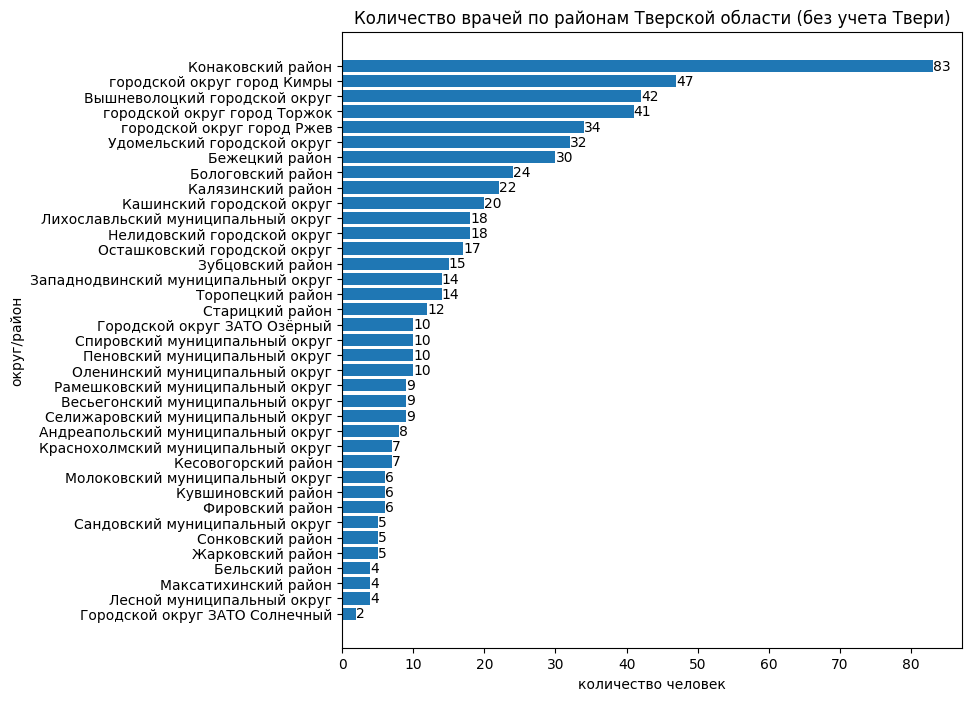

In [98]:
for_plt = docs_regions.query('region != "городской округ город Тверь"').sort_values(by='count')

fig, ax = plt.subplots(figsize=(8,8))

bars = plt.barh(for_plt['region'], for_plt['count'])
ax.bar_label(bars)


plt.title('Количество врачей по районам Тверской области (без учета Твери)')
plt.xlabel('количество человек')
plt.ylabel('округ/район')

plt.show()

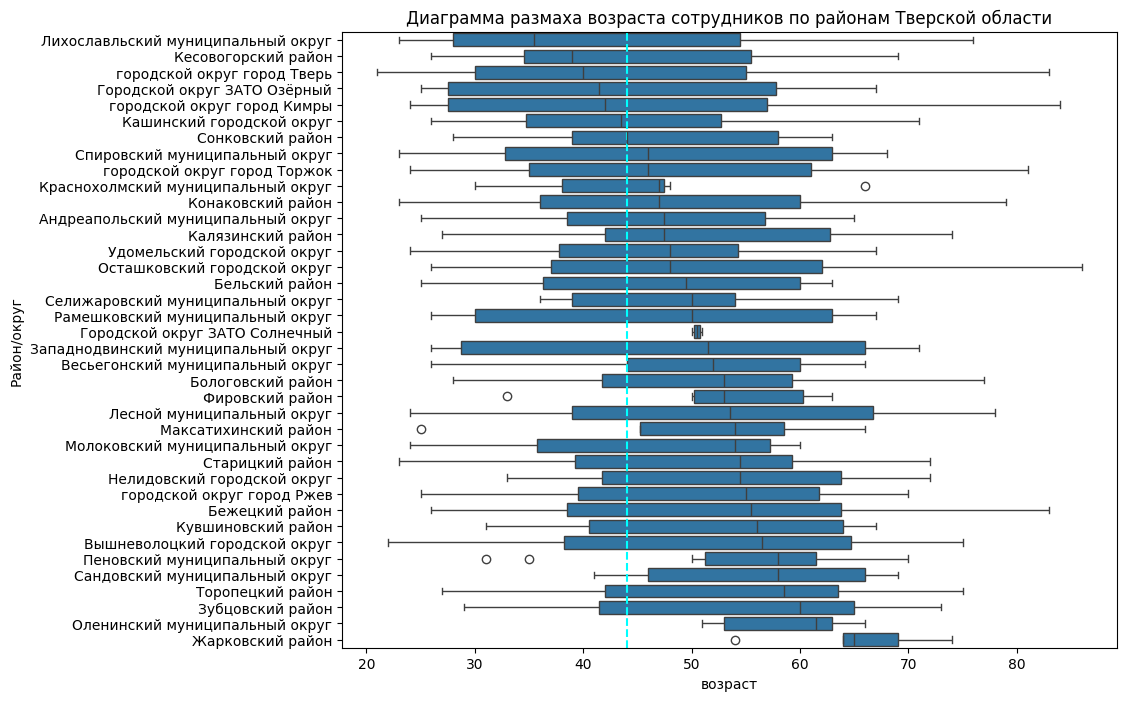

In [99]:
plt.figure(figsize=(10,8))

sns.boxplot(x='age',
            y='region',
            data=for_dl,
            order=for_dl.groupby('region')['age'].median().sort_values().index,
            orient='h')

plt.axvline(x=for_dl['age'].median(), c='cyan', ls='--')

plt.title('Диаграмма размаха возраста сотрудников по районам Тверской области')
plt.xlabel('возраст')
plt.ylabel('Район/округ')
plt.show()

В целом молодые специалисты работают преимущественно в Лихославльском МО, Кесовогорском р-не, Тверском городском округе, в городских округах Озерный, Кимры и Кашинский.

Визуализируем данные на карте, чтобы визуально оценить зависимость возраста сотрудников от удаленности от Твери.

In [100]:
# Ссылка на файл
url = 'https://drive.google.com/uc?id=1UkRGsiiz0X-iA5_5mX-ZJWBSZCHzqSSm'

# Скачивание файла
gdown.download(url, 'data.gpkg', quiet=False)

# Чтение файла
gdf = gpd.read_file('data.gpkg')

Downloading...
From: https://drive.google.com/uc?id=1UkRGsiiz0X-iA5_5mX-ZJWBSZCHzqSSm
To: /content/data.gpkg
100%|██████████| 897k/897k [00:00<00:00, 44.5MB/s]


In [101]:
gdf.columns

Index(['osm_ref', 'osm_vers', 'territory_id', 'year_from', 'year_to',
       't_dict_municipal_districts — Sheet1_municipal_district_name_short',
       't_dict_municipal_districts — Sheet1_oktmo',
       't_dict_municipal_districts — Sheet1_municipal_district_name',
       't_dict_municipal_districts — Sheet1_municipal_district_type',
       't_dict_municipal_districts — Sheet1_municipal_district_status',
       't_dict_municipal_districts — Sheet1_shape',
       't_dict_municipal_districts — Sheet1_shape_linked_oktmo',
       't_dict_municipal_districts — Sheet1_municipal_district_center',
       't_dict_municipal_districts — Sheet1_source_rosstat',
       't_dict_municipal_districts — Sheet1_year_from',
       't_dict_municipal_districts — Sheet1_year_to',
       't_dict_municipal_districts — Sheet1_territory_id',
       't_dict_municipal_districts — Sheet1_change_id_from',
       't_dict_municipal_districts — Sheet1_change_id_to',
       't_dict_municipal_districts — Sheet1_region_

In [102]:
#Нужный нам столбец
gdf['t_dict_municipal_districts — Sheet1_municipal_district_name_short'].head()

0    Вышний Волочек
1             Кимры
2              Ржев
3            Торжок
4             Тверь
Name: t_dict_municipal_districts — Sheet1_municipal_district_name_short, dtype: object

У нас уже есть файл в котором регионам из основного датафрейма расставлены по регионам из файла с полигонами.

In [103]:
regions.head()

Municipal District Name                              region
0          Андреапольский  Андреапольский муниципальный округ
1                Бежецкий                      Бежецкий район
2                Бельский                      Бельский район
3             Бологовский                   Бологовский район
4            Весьегонский    Весьегонский муниципальный округ

In [104]:
#Добавляем районы соответствующие районам из файла с полигонами
for_map = for_dl.merge(regions, on='region', how='left')
for_map.head(3)

birth_date  age   sex  \
0 1958-01-01   66  Муж.   
1 1968-11-13   55  Жен.   
2 1950-02-01   74  Муж.   

                                                                                                                    organization  \
0   ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ОБЛАСТНОЙ КЛИНИЧЕСКИЙ ПСИХОНЕВРОЛОГИЧЕСКИЙ ДИСПАНСЕР"   
1                       ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА №1"   
2  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КАЛИНИНСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА"   

                              position age_category          short_name  \
0       врач-анестезиолог-реаниматолог   с 60 до 69  ГБУЗ Окпнд г Тверь   
1                     рентгенолаборант   с 36 до 59        ГБУЗ "СП №1"   
2  врач общей практики (семейный врач)          70+        ГБУЗ "КЦРКБ"   

                        region                                    adds  \
0  городской округ город Тверь  170005, г. Тверь, ул. Фурманова, д. 12   
1  городской округ город Тверь      170001, г. Тверь, ул. Бакунина, 33   
2  городской округ город Тверь      170032, Тверь, п. Химинститута, 59   

                              coordinates  abbr          org_cat  \
0  56.871230795727044, 35.895732720311834  ГБУЗ  государственное   
1   56.856056597699265, 35.87171508211874  ГБУЗ  государственное   
2   56.796196770160655, 36.02370550191326  ГБУЗ  государственное   

                                   geopoint Municipal District Name  
0  [56.871230795727044, 35.895732720311834]             Калининский  
1   [56.856056597699265, 35.87171508211874]             Калининский  
2   [56.796196770160655, 36.02370550191326]             Калининский

In [105]:
#Расчитываем медианный возраст по добавленным
median_age = for_map.groupby('Municipal District Name')['age'].agg(['median', 'count']).reset_index()
median_age.head()

Municipal District Name  median  count
0          Андреапольский    47.5      8
1                Бежецкий    55.5     30
2                Бельский    49.5      4
3             Бологовский    53.0     24
4            Весьегонский    52.0      9

In [106]:
#Добавляем данный в датафрейм с полигонами
gdf = gdf.merge(median_age, left_on='t_dict_municipal_districts — Sheet1_municipal_district_name_short', right_on='Municipal District Name', how='left')

In [107]:
#Строим картограмму
# Центр карты
center = [57.041335, 34.960142]

# Создание карты
m = folium.Map(location=center, zoom_start=7.5)

# Добавляем Choropleth
choropleth = folium.Choropleth(
    geo_data=gdf,
    name="median",
    data=gdf,
    columns=["t_dict_municipal_districts — Sheet1_municipal_district_name_short", "median"],
    key_on="feature.properties.t_dict_municipal_districts — Sheet1_municipal_district_name_short",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Медианный возраст врачей"
).add_to(m)

#Добавляем всплывающие подсказки с названием районов
folium.GeoJsonTooltip(fields=["t_dict_municipal_districts — Sheet1_municipal_district_name_short", "median"], aliases=["Район:", "Медианный возраст:"]).add_to(choropleth.geojson)

# Отображаем карту
m

In [108]:
#Строим картограмму
# Центр карты
center = [57.041335, 34.960142]

# Создание карты
m = folium.Map(location=center, zoom_start=7.5)

list_of_thresholds = [0, 5, 10, 20, 50, 100, 200, 794]

# Добавляем Choropleth
choropleth = folium.Choropleth(
    geo_data=gdf,
    name='count',
    data=gdf,
    columns=['t_dict_municipal_districts — Sheet1_municipal_district_name_short', 'count'],
    key_on='feature.properties.t_dict_municipal_districts — Sheet1_municipal_district_name_short',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Количество врачей по районам',
    threshold_scale=list_of_thresholds  # Устанавливаем кастомные границы
).add_to(m)

#Добавляем всплывающие подсказки с названием районов
folium.GeoJsonTooltip(fields=['t_dict_municipal_districts — Sheet1_municipal_district_name_short', 'count', 'median'], aliases=['Район:', 'Количество врачей','Медианный возраст:']).add_to(choropleth.geojson)

# Отображаем карту
m

Действительно по карте мы видим, что более молодые сотрудники работают в Твери и  вблизи. Также можно отметить большое количество сотрудников в Твери и на юго-востоке области. Поэтому мы не можем утверждать, что из-за близости крупного города молодые сотрудники переезжают работать в Тверь, здесь нужно оценивать укомплектованность штата по численности группы населения  (например, численность населения старше 18 лет для оценки достаточности количества терапевтов, и количество детей для оценки укомплектованности педиатрами в районе).

### Вопрос 2

Подтверждаются ли предположения о том, что большинство медицинских работников первичной врачебной медико-санитарной помощи* в Тверской области пенсионного возраста, женщин в возрасте 60+ работает меньше, чем мужчин в возрасте 60+, а женщин в возрасте 30-50 лет работает больше, чем мужчин этого же возраста.

Молодые специалисты (до 35 лет) уезжают в другие регионы и не остаются работать ни в г. Твери, ни в районах Тверской области.


*первичная врачебная медико-санитарная помощь оказывается, врачами-терапевтами участковыми, врачами-педиатрами участковыми и врачами общей практики (семейными врачами).*


In [109]:
doctors_list = ['врач общей практики (семейный врач)', 'врач-терапевт участковый',
       'врач-педиатр участковый']

In [110]:
tver_df = for_dl.query('region == "городской округ город Тверь" and position.isin(@doctors_list)')

In [111]:
tver_df.head()

birth_date  age   sex  \
2 1950-02-01   74  Муж.   
4 1974-11-14   49  Жен.   
6 1946-03-10   78  Жен.   
7 1953-04-17   71  Жен.   
8 1966-01-18   58  Жен.   

                                                                                                                    organization  \
2  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КАЛИНИНСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА"   
4         ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КЛИНИЧЕСКАЯ БОЛЬНИЦА СКОРОЙ МЕДИЦИНСКОЙ ПОМОЩИ"   
6                              ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ГОРОДСКАЯ ПОЛИКЛИНИКА № 8"   
7                              ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ГОРОДСКАЯ ПОЛИКЛИНИКА № 8"   
8                        ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КЛИНИЧЕСКАЯ ДЕТСКАЯ БОЛЬНИЦА №2"   

                              position age_category     short_name  \
2  врач общей практики (семейный врач)          70+   ГБУЗ "КЦРКБ"   
4  врач общей практики (семейный врач)   с 36 до 59   ГБУЗ "КБСМП"   
6             врач-терапевт участковый          70+  ГБУЗ "ГП № 8"   
7  врач общей практики (семейный врач)          70+  ГБУЗ "ГП № 8"   
8              врач-педиатр участковый   с 36 до 59  ГБУЗ "КДБ №2"   

                        region                                  adds  \
2  городской округ город Тверь    170032, Тверь, п. Химинститута, 59   
4  городской округ город Тверь   170024, г. Тверь, ул. М. Конева, 71   
6  городской округ город Тверь  170001, г. Тверь, ул. Виноградова, 5   
7  городской округ город Тверь  170001, г. Тверь, ул. Виноградова, 5   
8  городской округ город Тверь     170023, г. Тверь, ул. Ржевская, 4   

                             coordinates  abbr          org_cat  \
2  56.796196770160655, 36.02370550191326  ГБУЗ  государственное   
4   56.84410852162348, 35.83136175796528  ГБУЗ  государственное   
6  56.856228625907406, 35.86422695419068  ГБУЗ  государственное   
7  56.856228625907406, 35.86422695419068  ГБУЗ  государственное   
8   56.85275598238039, 35.84721077626297  ГБУЗ  государственное   

                                  geopoint  
2  [56.796196770160655, 36.02370550191326]  
4   [56.84410852162348, 35.83136175796528]  
6  [56.856228625907406, 35.86422695419068]  
7  [56.856228625907406, 35.86422695419068]  
8   [56.85275598238039, 35.84721077626297]

In [112]:
other_df = for_dl.query('region != "городской округ город Тверь" and position.isin(@doctors_list)')

In [113]:
other_df.head()

birth_date  age   sex  \
48 1961-02-03   63  Муж.   
49 1944-11-22   79  Муж.   
50 1955-06-15   69  Муж.   
53 1962-12-06   61  Жен.   
54 1964-08-07   59  Жен.   

                                                                                                           organization  \
48      ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТАРИЦКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА"   
49    ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КОНАКОВСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА"   
50      ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТАРИЦКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА"   
53  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ВЫШНЕВОЛОЦКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА"   
54  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ВЫШНЕВОЛОЦКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА"   

                               position age_category  \
48  врач общей практики (семейный врач)   с 60 до 69   
49             врач-терапевт участковый          70+   
50  врач общей практики (семейный врач)   с 60 до 69   
53              врач-педиатр участковый   с 60 до 69   
54              врач-педиатр участковый   с 36 до 59   

                  short_name                         region  \
48      ГБУЗ "СТАРИЦКАЯ ЦРБ"                Старицкий район   
49               ГБУЗ "КЦРБ"              Конаковский район   
50      ГБУЗ "СТАРИЦКАЯ ЦРБ"                Старицкий район   
53  ГБУЗ "ВЫШНЕВОЛОЦКАЯ ЦРБ"  Вышневолоцкий городской округ   
54  ГБУЗ "ВЫШНЕВОЛОЦКАЯ ЦРБ"  Вышневолоцкий городской округ   

                                                                adds  \
48    171360, Тверская область, г. Старица, ул. Коммунистическая, 41   
49        171252, Тверская область, г. Конаково, ул. Энергетиков, 32   
50    171360, Тверская область, г. Старица, ул. Коммунистическая, 41   
53  171163, Тверская область, г. Вышний Волочёк, ул. Новгородская, 1   
54  171163, Тверская область, г. Вышний Волочёк, ул. Новгородская, 1   

                              coordinates  abbr          org_cat  \
48  56.52006588874049, 34.933129900615654  ГБУЗ  государственное   
49  56.71481749838063, 36.783796958204114  ГБУЗ  государственное   
50  56.52006588874049, 34.933129900615654  ГБУЗ  государственное   
53  57.585076121320846, 34.54954178537322  ГБУЗ  государственное   
54  57.585076121320846, 34.54954178537322  ГБУЗ  государственное   

                                   geopoint  
48  [56.52006588874049, 34.933129900615654]  
49  [56.71481749838063, 36.783796958204114]  
50  [56.52006588874049, 34.933129900615654]  
53  [57.585076121320846, 34.54954178537322]  
54  [57.585076121320846, 34.54954178537322]

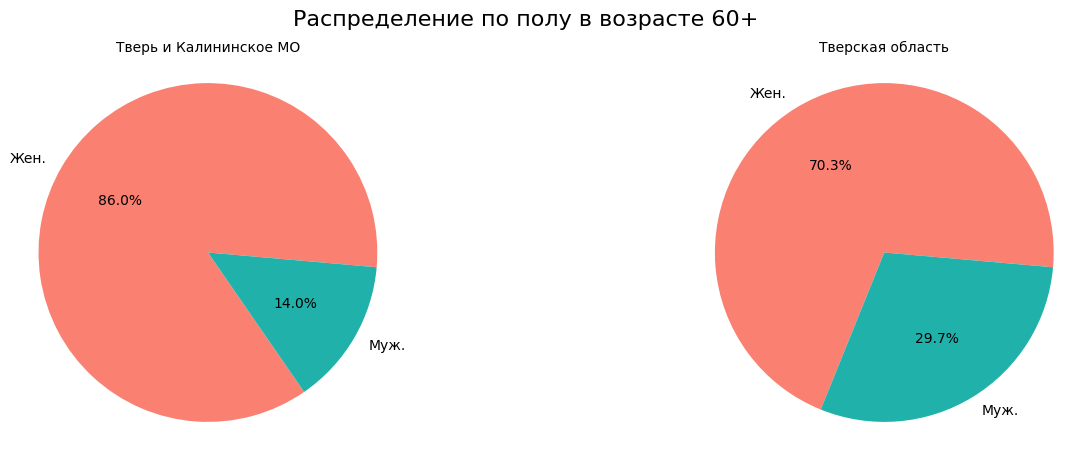

In [114]:
plt.figure(figsize=(16, 5))
plt.suptitle('Распределение по полу в возрасте 60+', fontsize=16)


plt.subplot(1,2,1)
plt.pie(tver_df.query('age >= 60').groupby('sex', as_index=False)['age'].count()['age'],
        autopct='%1.1f%%',
        labels=tver_df.query('age >= 60').groupby('sex', as_index=False)['age'].count()['sex'],
        colors=['salmon', 'lightseagreen'],
        startangle=(-5),
       radius=(1.1))
plt.title('Тверь и Калининское МО', fontsize=10)

plt.subplot(1,2,2)
plt.pie(other_df.query('age >= 60').groupby('sex', as_index=False)['age'].count()['age'],
        autopct='%1.1f%%',
        labels=other_df.query('age >= 60').groupby('sex', as_index=False)['age'].count()['sex'],
        colors=['salmon', 'lightseagreen'],
        startangle=(-5),
       radius=(1.1))
plt.title('Тверская область', fontsize=10)

plt.show()

In [115]:
#Тверь
tver_df.query('age >= 60')['sex'].value_counts()

sex
Жен.    43
Муж.     7
Name: count, dtype: int64

In [116]:
#Тверская область
other_df.query('age >= 60')['sex'].value_counts()

sex
Жен.    78
Муж.    33
Name: count, dtype: int64

Среди врачей первичной врачебной медико-санитарной помощи **больше женщин** в целом по всему региону, но в доля области мужчин в два раза больше, чем в Твери. И сотрудников в возрасте 60+ больше работает в области.

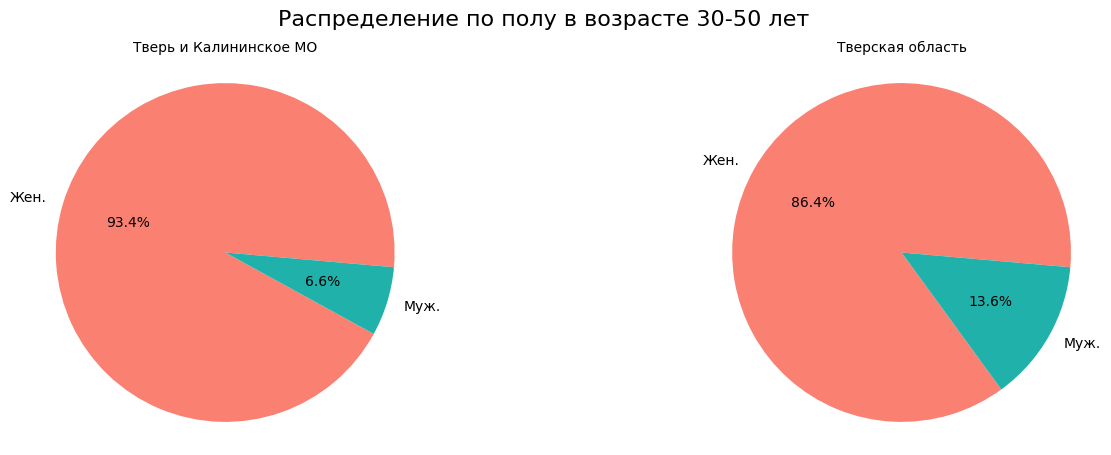

In [117]:
plt.figure(figsize=(16, 5))
plt.suptitle('Распределение по полу в возрасте 30-50 лет', fontsize=16)


plt.subplot(1,2,1)
plt.pie(tver_df.query('30 <= age <=50').groupby('sex', as_index=False)['age'].count()['age'],
        autopct='%1.1f%%',
        labels=tver_df.query('30 <= age <=50').groupby('sex', as_index=False)['age'].count()['sex'],
        colors=['salmon', 'lightseagreen'],
        startangle=(-5),
       radius=(1.1))
plt.title('Тверь и Калининское МО', fontsize=10)

plt.subplot(1,2,2)
plt.pie(other_df.query('30 <= age <=50').groupby('sex', as_index=False)['age'].count()['age'],
        autopct='%1.1f%%',
        labels=other_df.query('30 <= age <=50').groupby('sex', as_index=False)['age'].count()['sex'],
        colors=['salmon', 'lightseagreen'],
        startangle=(-5),
       radius=(1.1))
plt.title('Тверская область', fontsize=10)

plt.show()

In [118]:
#Тверь
tver_df.query('30 <= age <=50')['sex'].value_counts()

sex
Жен.    85
Муж.     6
Name: count, dtype: int64

In [119]:
#Тверская область
other_df.query('30 <= age <=50')['sex'].value_counts()

sex
Жен.    89
Муж.    14
Name: count, dtype: int64

Подобная ситуация и с врачами в возрасте 30-50 лет. Но в этом возрасте еще бОльшая доля женцин.

In [120]:
#Оценим долю молодых специалистов

print(f'Всего врачей в Твери и Калининском МО: {tver_df["age"].count()}')
print(f'Количество молодых специалистов (до 35 лет): {tver_df.query("age <=35")["age"].count()}')
print()
print(f'Доля молодых специалистов в Твери и Калининском МО: {round(tver_df.query("age <=35")["age"].count() / tver_df["age"].count() * 100, 1)}%')


Всего врачей в Твери и Калининском МО: 280
Количество молодых специалистов (до 35 лет): 149

Доля молодых специалистов в Твери и Калининском МО: 53.2%


In [121]:
print(f'Всего врачей в Тверской области: {other_df["age"].count()}')
print(f'Количество молодых специалистов (до 35 лет): {other_df.query("age <=35")["age"].count()}')
print()
print(f'Доля молодых специалистов в Тверской области: {round(other_df.query("age <=35")["age"].count() / other_df["age"].count() * 100, 1)}%')

Всего врачей в Тверской области: 334
Количество молодых специалистов (до 35 лет): 95

Доля молодых специалистов в Тверской области: 28.4%


Да, действительно доля молодых специалистов до 35 лет больше в Твери и Калининском МО. Это может быть связано как с более высоким уровнем оплаты труда, так и с направлением на работу. В целом в наших данных большинство учреждений государственные.

### Вопрос 3

Не менее 50 выпускников Университета (24-27 лет) устроились работать в этом году в систему оказания первичной врачебной медико-санитарной помощи городе Тверь и Тверской области. При этом, в городе Твери выпускников Университета устроилось работать больше, чем в области.

Так как у нас нет конкретных данных по выпускникам, мы возьмем общее число врачей в возрасте 24-27 лет и оценим их долю.

In [122]:
#Оценим выпускников в Твери

print(f'Всего врачей в Твери и Калининском МО: {tver_df["age"].count()}')
print(f'Количество выпускников (24-27 лет): {tver_df.query("24<= age <=27")["age"].count()}')
print()
print(f'Доля выпускников в Твери и Калининском МО: {round(tver_df.query("24<= age <=27")["age"].count() / tver_df["age"].count() * 100, 1)}%')

Всего врачей в Твери и Калининском МО: 280
Количество выпускников (24-27 лет): 72

Доля выпускников в Твери и Калининском МО: 25.7%


In [123]:
#Оценим выпускников в Тверской области

print(f'Всего врачей в Тверской области: {other_df["age"].count()}')
print(f'Количество выпускников (24-27 лет): {other_df.query("24<= age <=27")["age"].count()}')
print()
print(f'Доля выпускников в Тверской области: {round(other_df.query("24<= age <=27")["age"].count() / other_df["age"].count() * 100, 1)}%')

Всего врачей в Тверской области: 334
Количество выпускников (24-27 лет): 44

Доля выпускников в Тверской области: 13.2%


В результате мы видим, что доля выпускников в Твери в два раза больше, чем в области. Всего выпускников в наших данных - 116 человек, из них 72 осталось работать в Твери.

##Вывод

По результатам проведенного анализа можем выделить следующее:

Всего врачей в наших данных 1413 человек

Наибольшее количество сотрудников работает по специальности - рентгенолаборант, наименьшее - врач рентгенолог и хирург. Врачей по специальности участковый терапевт и педиатр одинаковое количество почти по 150 человек.

**Медианный возраст сотрудников - 44 года.**

Основное количество сотрудников (чуть более 600 человек) в возрасте с 36 по 59 лет. Также в группе 70+ у нас почти 100 человек. Важно понимать, сотрудники из этой категории уходят на пенсию, и необходимо готовить специалистов для их замены.

**Женщин в мед организациях работает в два раза больше, чем мужчин.**
Мужчины работают в основном по специальностям **врач-хирург** (почти 75% мужчин в этой специальности) и **анестезиолог-реаниматолог** (почти 63%). При этом медианный возраст мужчин хирургов и женщин хирургов одинаковый 48 лет, а анестезиологов-реаниматологов нет, у мужчин медианный возраст почти 48 лет, у женщин 39.

Больше всего женщин работает по специальности **врач-педиатр** - 91% (медианный возраст 41 год), **рентгенолаборант** - 88%, **врач-терапевт** почти 86%, **врач общей практики** - 73% женщин (медианный возраст женщин 50 лет). Большая разница в медианном возрасте рентгенолаборантов, где у женщин медианный возраст 48, у мужчин 37 лет.
Можно сказать, что наиболее равномерное распределение по полу в специальности **врач-рентгенолог**, где работает 59% женщин и 41% мужчин. С медианным возрастом у женщин 45 лет, у мужчин 48 лет.

Подавляющее большинство сотрудников из нашей выборки работает в государственных медицинских учреждениях, почти 1200 человек.

**Ответы на поставленные вопросы:**
1.	В целом молодые специалисты работают преимущественно в Лихославльском МО, Кесовогорском р-не, Тверском городском округе, в городских округах Озерный, Кимры и Кашинский. Действительно мы видим, что более молодые сотрудники работают в Твери и вблизи. Также можно отметить большое количество сотрудников в Твери и на юго-востоке области. Поэтому мы не можем утверждать, что из-за близости крупного города молодые сотрудники переезжают работать в Тверь, здесь нужно оценивать укомплектованность штата по численности группы населения (например, численность населения старше 18 лет для оценки достаточности количества терапевтов, и количество детей для оценки укомплектованности педиатрами в районе).
2.	Да, действительно доля молодых специалистов до 35 лет больше в Твери и Калининском МО. Это может быть связано как с более высоким уровнем оплаты труда, так и с направлением на работу. В целом в наших данных большинство учреждений государственные.
3.	В результате мы видим, что доля выпускников в Твери в два раза больше, чем в области. Всего выпускников в наших данных - 116 человек, из них 72 осталось работать в Твери.